In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
# TODO: change this to yours ...
DATA_DIR = "/Users/kwongtszkong/Desktop/STAT3612 Statistical ML/Group Project/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)




with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [3]:
def aggregate_admission_data(df, ehr_dict, aggregation, has_labels=True):
    """Aggregate features per admission with optional labels"""
    admission_ids = df['id'].unique()
    X = []
    y = [] if has_labels else None
    
    for adm_id in admission_ids:
        adm_rows = df[df['id'] == adm_id]
        adm_features = ehr_dict[adm_id]
        
        if aggregation == 'last':
            features = adm_features[-1]
        elif aggregation == 'mean':
            features = np.mean(adm_features, axis=0)
        elif aggregation == 'max':
            features = np.max(adm_features, axis=0)
        else:
            raise ValueError("Invalid aggregation method")
        
        X.append(features)
        
        if has_labels:
            y.append(adm_rows['readmitted_within_30days'].iloc[0])
    
    return np.array(X), (np.array(y) if has_labels else None)

# Process datasets
X_train, y_train = aggregate_admission_data(train_df, ehr_data["feat_dict"], 'mean') # change last/max/mean
X_val, y_val = aggregate_admission_data(val_df, ehr_data["feat_dict"], 'mean') 
X_test = aggregate_admission_data(test_df, ehr_data["feat_dict"], 'mean', has_labels=False)[0]

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Shapes - Train: (8234, 171), Val: (2788, 171), Test: (2741, 171)


In [4]:

from scipy.stats import pointbiserialr, chi2_contingency
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]  

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []

for i in range(X_train.shape[1]):
    feature_name = feature_names[i]
    
    # Skip constant features
    if np.std(X_train[:, i]) == 0:
        correlations.append(0)
        p_values.append(1)
        continue
        
    # Use chi-squared for ICD features, point-biserial for others
    if feature_name in ehr_data["icd_cols"]:
        # Chi-squared test for binary ICD features
        contingency_table = pd.crosstab(X_train[:, i], y_train)
        try:
            chi2, pval, _, _ = chi2_contingency(contingency_table)
            correlations.append(chi2)  # Using chi2 statistic as effect size
            p_values.append(pval)
        except:
            correlations.append(0)
            p_values.append(1)
    else:
        # Point-biserial for continuous features
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)
        


# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',
    
    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',
    
    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.95     # Demographics rarely zero
    },
    'std_dev': 0.001,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.001,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]
        
        # Skip binary features for variance check
        check_variance = ftype not in ['icd']
        
        if ftype == 'icd':
            sig_threshold = 0.05  # Could use different threshold for chi-square
            effect_size = row['Correlation']  # Actually contains chi2 statistic
        else:
            sig_threshold = thresholds['correlation']['max_pvalue']
            effect_size = np.abs(row['Correlation'])
        
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (effect_size < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > sig_threshold):
            if feature not in clinically_relevant:
                features_to_remove.append(feature)
            


    
filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features) 
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)
X_test_filtered =remove_features(X_test, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features) 
                     if i not in remove_indices]



print(X_train_filtered.shape)






(8234, 133)


/var/folders/79/xhsm8rlj5fz4b46rjy_ls9t40000gn/T/ipykernel_71571/611880398.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [5]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

def compute_feature_associations(X, y, feature_names, ehr_data):
    correlations = []
    p_values = []
    
    for i in range(X.shape[1]):
        if np.std(X[:, i]) == 0:  
            correlations.append(0)
            p_values.append(1)
            continue
            
        if feature_names[i] in ehr_data["icd_cols"]:
            # Chi-squared for ICD features
            contingency = pd.crosstab(X[:, i], y)
            try:
                chi2, pval, _, _ = chi2_contingency(contingency)
                correlations.append(chi2)
                p_values.append(pval)
            except:
                correlations.append(0)
                p_values.append(1)
        else:
            # Point-biserial for continuous features
            corr, pval = pointbiserialr(X[:, i], y)
            correlations.append(corr)
            p_values.append(pval)
    
    return pd.DataFrame({
        'Feature': feature_names,
        'Association': correlations,
        'P-value': p_values
    })

# 2. Function to identify highly correlated features
def find_collinear_features(X, feature_names, threshold=0.8):
    """Identify feature pairs with correlation > threshold"""
    corr_matrix = pd.DataFrame(X).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    collinear_pairs = [(feature_names[i], feature_names[j], corr_matrix.iloc[i,j]) 
                      for i,j in zip(*np.where(upper > threshold))]
    return pd.DataFrame(collinear_pairs, columns=['Feature1', 'Feature2', 'Correlation'])

# 3. Feature selection based on clinical relevance and collinearity
def select_non_collinear_features(X, feature_names, ehr_data, 
                                clinically_relevant, corr_threshold=0.8):
    # Standardize data for proper correlation calculation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find all collinear pairs
    collinear_df = find_collinear_features(X_scaled, feature_names, corr_threshold)
    
    # Get feature importance scores
    importance = mutual_info_classif(X, y_train, random_state=42)
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    
    features_to_keep = set(clinically_relevant)  # Always keep these
    
    # For non-clinical features, keep the more important one from collinear pairs
    for _, row in collinear_df.iterrows():
        f1, f2 = row['Feature1'], row['Feature2']
        
        # Skip if either is clinically relevant
        if f1 in clinically_relevant or f2 in clinically_relevant:
            continue
            
        # Keep feature with higher importance
        imp1 = importance_df.loc[importance_df['Feature'] == f1, 'Importance'].values[0]
        imp2 = importance_df.loc[importance_df['Feature'] == f2, 'Importance'].values[0]
        
        if imp1 > imp2:
            features_to_keep.add(f1)
        else:
            features_to_keep.add(f2)
    
    # Add any features not involved in collinearity
    all_features = set(feature_names)
    features_to_keep.update(all_features - set(collinear_df[['Feature1','Feature2']].values.flatten()))
    
    # Get indices of features to keep
    keep_indices = [i for i, f in enumerate(feature_names) if f in features_to_keep]
    remaining_features = [f for f in feature_names if f in features_to_keep]
    
    return keep_indices, remaining_features



# 1. Compute associations with target
assoc_df = compute_feature_associations(X_train_filtered, y_train, remaining_features, ehr_data)

# 2. Find and handle collinearity
keep_indices, non_collinear_features = select_non_collinear_features(
    X_train_filtered,
    remaining_features,
    ehr_data,
    clinically_relevant,
    corr_threshold=0.7  # Adjust based on your needs
)

# 3. Apply final filtering
X_train_final = X_train_filtered[:, keep_indices]
X_val_final = X_val_filtered[:, keep_indices]
X_test_final = X_test_filtered[:, keep_indices]





In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler

#standardization



# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_final)

# Use the same scaler to transform the validation and test data
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)


# Define the parameter grid
param_grid = {
    'C': np.logspace(-3, 1, 20),  # Test values from 0.001 to 10 (log scale)
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],  # Test different L1/L2 mixes
    'solver': ['saga'],  # Only solver that supports Elastic Net
    'penalty': ['elasticnet'],
    'max_iter': [1000]  # Ensure convergence
}

# Initialize the model
elastic_net = LogisticRegression(random_state=42)

# Use AUROC as the scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit on the training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best AUROC (CV):", grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ 

Best parameters: {'C': 0.0026366508987303583, 'l1_ratio': 0, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best AUROC (CV): 0.7575920180194929


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def compare_aggregations(train_df, val_df, ehr_dict, aggregation_methods):
    results = {}
    
    for method in aggregation_methods:
        # Process data with current aggregation
        X_train, y_train = aggregate_admission_data(train_df, ehr_dict, method)
        X_val, y_val = aggregate_admission_data(val_df, ehr_dict, method)
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train L2 (Ridge) model
        model = LogisticRegression(
            penalty='l2',
            C=0.001,  # From your earlier tuning
            solver='saga',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        
        # Predict and evaluate
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
        auroc = roc_auc_score(y_val, y_val_proba)
        
        results[method] = {
            'model': model,
            'auroc': auroc,
            'fpr': roc_curve(y_val, y_val_proba)[0],
            'tpr': roc_curve(y_val, y_val_proba)[1]
        }
    
    return results

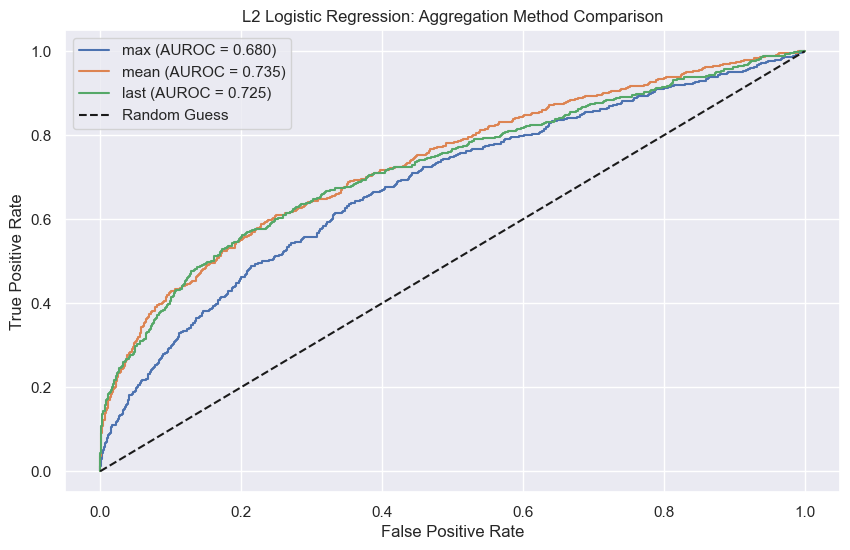

In [8]:
# Define aggregations to test
aggregation_methods = ['max', 'mean', 'last']

# Compare performance
results = compare_aggregations(train_df, val_df, ehr_data["feat_dict"], aggregation_methods)
plt.figure(figsize=(10, 6))
for method, result in results.items():
    plt.plot(result['fpr'], result['tpr'], 
             label=f'{method} (AUROC = {result["auroc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('L2 Logistic Regression: Aggregation Method Comparison')
plt.legend()
plt.show()

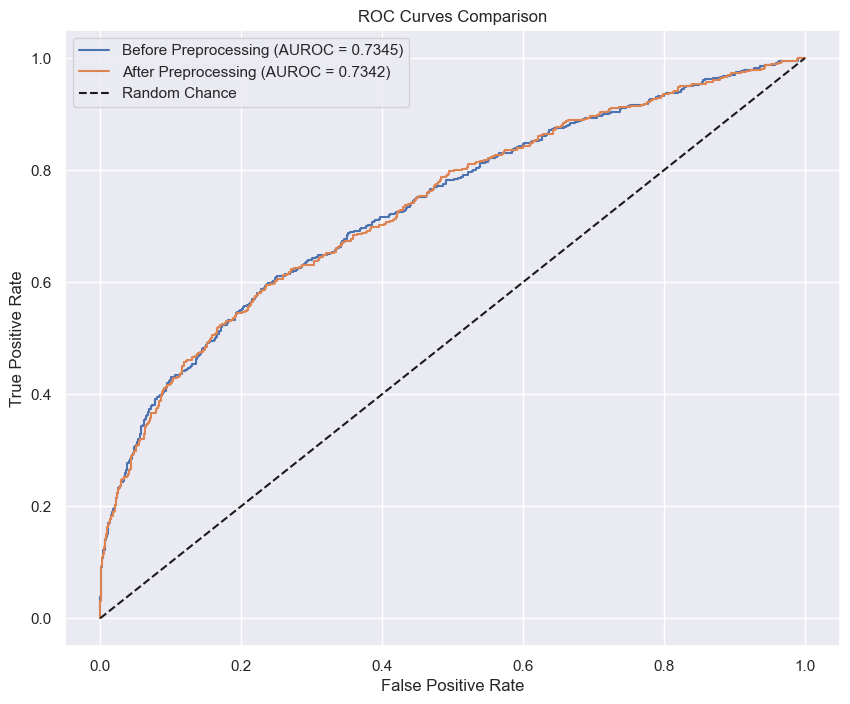

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Assumed data setup: X_train, X_val, y_train, y_val, X_train_final, X_val_final

# Initialize L2 model with your best parameters
model = LogisticRegression(
    penalty='l2',
    C=0.001,  # From your hyperparameter tuning
    solver='saga',
    max_iter=1000,
    random_state=42
)

# Dictionary to store results
results = {
    'Before Preprocessing': {'X_train': X_train, 'X_val': X_val},
    'After Preprocessing': {'X_train': X_train_final, 'X_val': X_val_final}
}

# Train and evaluate for both scenarios
for scenario, data in results.items():
    # Standardize (important for fair comparison)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(data['X_train'])
    X_val_scaled = scaler.transform(data['X_val'])
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predict probabilities
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Store results
    results[scenario]['auroc'] = roc_auc_score(y_val, y_val_proba)
    results[scenario]['fpr'], results[scenario]['tpr'], _ = roc_curve(y_val, y_val_proba)

# Visualization of ROC curves
plt.figure(figsize=(10, 8))
for scenario, data in results.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{scenario} (AUROC = {data['auroc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='best')
plt.show()